In [3]:
%pip install -q langgraph-supervisor langchain-tavily

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# lets load variables in .env 
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
# initialize the chat model
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.5-flash", model_provider="google_vertexai")

In [3]:
# Lets create a web_search_agent
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=2)

In [4]:
results = web_search_tool.invoke("Who won IPL 2025?")
results

{'query': 'Who won IPL 2025?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Yesterday's IPL Match Result: Who won IPL 2025 crown last night, RCB or ...",
   'url': 'https://economictimes.indiatimes.com/news/sports/yesterdays-ipl-match-result-who-won-ipl-2025-crown-last-night-rcb-or-pbks-narendra-modi-stadium-hosts-one-for-the-history-books/articleshow/121609813.cms',
   'content': "Royal Challengers Bengaluru defeated Punjab Kings in a thrilling IPL 2025 final. RCB secured their first-ever IPL title after an 18-year wait. The match went down to the wire, with RCB winning by 6 runs. Krunal Pandya was named Man of the Match for his economical bowling. Shashank Singh's brilliant knock went in vain.",
   'score': 0.9253988,
   'raw_content': None},
  {'title': 'Who won IPL 2025? What happened in the final between RCB and PBKS?',
   'url': 'https://www.sportingnews.com/in/ipl/news/who-won-ipl-2025-what-happened-final-rcb-pbks/66f5c418beb57649f8a6b6bb

In [7]:
system_message_prompt_research = "You are a research agent. Instructions: only assist with research kind of topics dont do anything logical such as math, Respond only with results of your work"

In [9]:
from IPython.display import display, Image
def display_graph(agent):
    display(Image(agent.get_graph().draw_mermaid_png()))

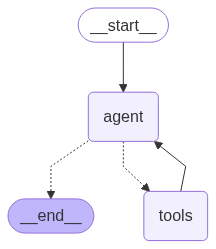

In [10]:
# lets create  areact agent for websearch
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage
web_search_agent = create_react_agent(
    model=llm,
    tools=[web_search_tool],
    prompt=SystemMessage(content=system_message_prompt_research),
    name="web_research_agent"
)
display_graph(web_search_agent)

In [14]:
from langchain_core.messages import HumanMessage
result = web_search_agent.invoke({
    "messages": [HumanMessage(content="Who won IPL 2024?")]
})


In [15]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

Who won IPL 2024?
================================== Ai Message ==================================
Name: web_research_agent
Tool Calls:
  tavily_search (191f5d1a-4b53-429a-a968-70029d77db3d)
 Call ID: 191f5d1a-4b53-429a-a968-70029d77db3d
  Args:
    search_depth: basic
    query: Who won IPL 2024?
================================= Tool Message =================================
Name: tavily_search

{"query": "Who won IPL 2024?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "2024 Indian Premier League final - Wikipedia", "url": "https://en.wikipedia.org/wiki/2024_Indian_Premier_League_final", "content": "^ _**a**__**b**__**c**_\"IPL 2024 final result: Kolkata Knight Riders beat Sunrisers Hyderabad to win title\". | Participating Teams | | Group A | * Mumbai Indians * Kolkata Knight Riders * Rajasthan Royals * Delhi Capitals * Lucknow Super Giants | | --- | | Group B | * S

In [16]:
def add(a: int, b: int) -> int:
    """Adds two numbers

    Args:
        a (int): a
        b (int): b

    Returns:
        int: returns a + b
    """
    return a + b

def sub(a: int, b: int) -> int:
    """sub two numbers

    Args:
        a (int): a
        b (int): b

    Returns:
        int: returns a - b
    """
    return a - b

In [18]:
math_agent = create_react_agent(
    model=llm,
    tools=[add, sub],
    prompt=(
        "You are a math agent\n"
        "Instructions\n"
        "Assist only in math related tasks"
        "Respons only with results"
        
    ),
    name="math_agent"
)

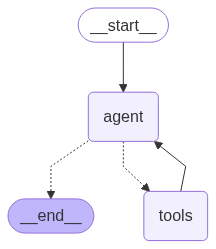

In [19]:
display_graph(math_agent)

In [20]:
from langchain_core.messages import HumanMessage
result = math_agent.invoke({
    "messages": [HumanMessage(content="What is 30 plus 20?")]
})

In [21]:
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 30 plus 20?
================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (b47bae0b-c33c-4062-a6ca-3011888e0cb3)
 Call ID: b47bae0b-c33c-4062-a6ca-3011888e0cb3
  Args:
    b: 20.0
    a: 30.0
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================
Name: math_agent

The answer is 50.


In [22]:
# Creating a supervisor agent
from langgraph_supervisor import create_supervisor
supervisor = create_supervisor(
    model=llm,
    agents=[web_search_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents \n"
        " - web_search agent. Assign search or research related tasks to this agent \n"
        " - math agent, Assing math related tasks to this agent \n"
        "Assign work to one agent at a time, do not call agents in parallel \n"
        "Do not work yourself"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

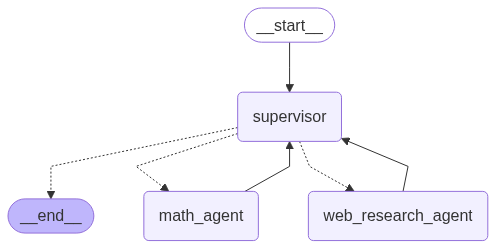

In [23]:
display_graph(supervisor)

In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            HumanMessage(content="Find the revenue of Tesla and add it revenue of SpaceX")
        ]
    }
):
    
    print(chunk)

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Find the revenue of Tesla and add it revenue of SpaceX', additional_kwargs={}, response_metadata={}, id='9742cf39-e549-4316-bae9-4c0ec933c23d'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_web_research_agent', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 110, 'candidates_token_count': 9, 'total_token_count': 221, 'prompt_tokens_details': [{'modality': 1, 'token_count': 110}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 9}], 'thoughts_token_count': 102, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -2.3967547946506076, 'model_name': 'gemini-2.5-flash'}, name='supervisor', id='run--1114ab15-fc71-427e-8f9f-8444356322e0-0', tool_calls=[{'name': 'transfer_to_web_research_agent', 'args': {}, 'id': '0509f04f-2793-4fef-9bc8-3dff48b6de48', 'type': 'tool_call'

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'supervisor': {'messages': [HumanMessage(content='Find the revenue of Tesla and add it revenue of SpaceX', additional_kwargs={}, response_metadata={}, id='9742cf39-e549-4316-bae9-4c0ec933c23d'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_web_research_agent', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 110, 'candidates_token_count': 9, 'total_token_count': 221, 'prompt_tokens_details': [{'modality': 1, 'token_count': 110}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 9}], 'thoughts_token_count': 102, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -2.3967547946506076, 'model_name': 'gemini-2.5-flash'}, name='supervisor', id='run--1114ab15-fc71-427e-8f9f-8444356322e0-0', tool_calls=[{'name': 'transfer_to_web_research_agent', 'args': {}, 'id': '0509f04f-2793-4fef-9bc8-3dff48b6de48', 'type': 'tool_call'

In [25]:
response = supervisor.invoke(
    {
        "messages": [
            HumanMessage(content="Find the revenue of Tesla and add it revenue of SpaceX")
        ]
    }
)
    

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


In [26]:
response['messages']

[HumanMessage(content='Find the revenue of Tesla and add it revenue of SpaceX', additional_kwargs={}, response_metadata={}, id='66d10688-56df-49f1-800d-69b9fccbbe65'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_web_research_agent', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 110, 'candidates_token_count': 9, 'total_token_count': 242, 'prompt_tokens_details': [{'modality': 1, 'token_count': 110}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 9}], 'thoughts_token_count': 123, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -5.378526475694445, 'model_name': 'gemini-2.5-flash'}, name='supervisor', id='run--6a236d53-65f8-48a4-a1fd-a8ca757b6c0c-0', tool_calls=[{'name': 'transfer_to_web_research_agent', 'args': {}, 'id': '8feef603-fcf8-4864-9c5f-a8877edb8ab5', 'type': 'tool_call'}], usage_metadata={'input_t

In [27]:
response['messages'][-1].pretty_print()

================================== Ai Message ==================================
Name: supervisor

The combined revenue of Tesla and SpaceX for 2023 is $105,773,000,000.
